<a href="https://colab.research.google.com/github/anandvardhan09/Bitcoin_Price_Predictor/blob/main/BTC_Price_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import warnings
import math
warnings.filterwarnings('ignore')

# Set the ticker symbol for Bitcoin
ticker_symbol = 'BTC-USD'
period = '356d'
interval = '1d'

# Getting the BTC data

[*********************100%***********************]  1 of 1 completed

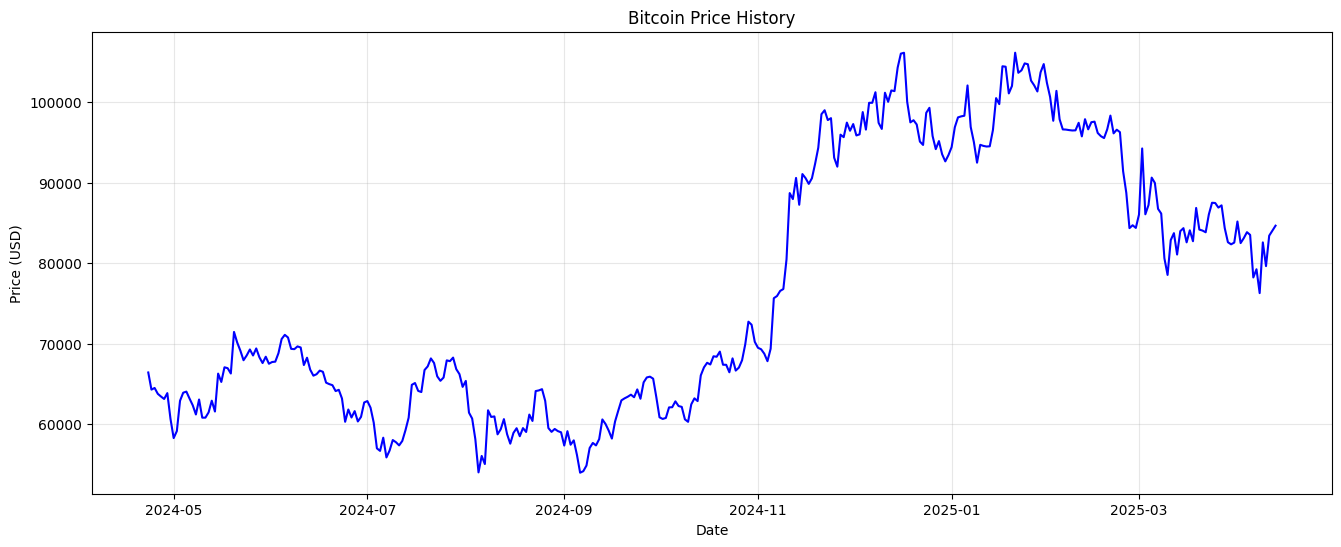

In [21]:
# Function to calculate RSI (before we use it)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Download Bitcoin data
print("Downloading Bitcoin data...")
bitcoin_data = yf.download(ticker_symbol, period=period, interval=interval)

# Visualize the raw data
plt.figure(figsize=(16, 6))
plt.plot(bitcoin_data.index, bitcoin_data['Close'], color='blue')
plt.title('Bitcoin Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, alpha=0.3)
plt.show()

# Feature Engineering

In [22]:
print("Performing feature engineering...")
bitcoin_data['Returns'] = bitcoin_data['Close'].pct_change()
bitcoin_data['MA7'] = bitcoin_data['Close'].rolling(window=7).mean()
bitcoin_data['MA30'] = bitcoin_data['Close'].rolling(window=30).mean()
bitcoin_data['Volatility'] = bitcoin_data['Returns'].rolling(window=7).std()
bitcoin_data['RSI'] = calculate_rsi(bitcoin_data['Close'], 14)
bitcoin_data.dropna(inplace=True)

# Prepare data for modeling
def prepare_data_for_lstm(df, feature_columns, target_column, look_back=10):
    df_features = df[feature_columns].values
    df_target = df[target_column].values

    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    df_features_scaled = scaler_X.fit_transform(df_features)
    df_target_scaled = scaler_y.fit_transform(df_target.reshape(-1, 1))

    X, y = [], []
    for i in range(look_back, len(df_features_scaled)):
        X.append(df_features_scaled[i-look_back:i])
        y.append(df_target_scaled[i])

    X, y = np.array(X), np.array(y)
    return X, y, scaler_X, scaler_y

Performing feature engineering...


# **MODEL**

In [24]:
# Function to create LSTM model
def create_lstm_model(input_shape, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to evaluate model
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Naive model (using yesterday's price as prediction)
    naive_pred = y_true[:-1]
    naive_true = y_true[1:]
    naive_mse = mean_squared_error(naive_true, naive_pred)
    improvement = (1 - mse/naive_mse) * 100 if naive_mse > 0 else 0

    print(f"\n--- {model_name} Evaluation Metrics ---")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"Improvement over naive model: {improvement:.2f}%")

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'improvement': improvement}

# Implement Walk-Forward Validation
def walk_forward_validation(data, feature_cols, target_col, train_size=0.7, validation_steps=5):
    results = {'lstm': [], 'arima': [], 'xgboost': []}
    all_predictions = {'lstm': [], 'arima': [], 'xgboost': []}
    all_actuals = []

    total_size = len(data)
    initial_train_size = int(total_size * train_size)
    step_size = int((total_size - initial_train_size) / validation_steps)

    for i in range(validation_steps):
        print(f"\n--- Walk-Forward Validation Step {i+1}/{validation_steps} ---")

        if i == validation_steps - 1:
            # For the last step, use all remaining data
            train_end = total_size - step_size
            test_start = train_end
            test_end = total_size
        else:
            train_end = initial_train_size + i * step_size
            test_start = train_end
            test_end = test_start + step_size

        train_data = data.iloc[:train_end].copy()
        test_data = data.iloc[test_start:test_end].copy()

        print(f"Training with data from {train_data.index[0]} to {train_data.index[-1]}")
        print(f"Testing with data from {test_data.index[0]} to {test_data.index[-1]}")

        # Store actual values for comparison
        actual_values = test_data[target_col].values
        all_actuals.extend(actual_values)

        # 1. LSTM Model
        look_back = 10
        X_train, y_train, scaler_X_lstm, scaler_y_lstm = prepare_data_for_lstm(
            train_data, feature_cols, target_col, look_back
        )

        # Prepare test data for LSTM
        X_test, y_test = [], []
        test_features = train_data[feature_cols].iloc[-look_back:].values
        test_features = np.vstack((test_features, test_data[feature_cols].values))
        test_features_scaled = scaler_X_lstm.transform(test_features)

        for j in range(look_back, look_back + len(test_data)):
            X_test.append(test_features_scaled[j-look_back:j])
        X_test = np.array(X_test)

        # Train LSTM model
        lstm_model = create_lstm_model((look_back, len(feature_cols)))
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lstm_model.fit(
            X_train, y_train,
            epochs=50,  # Reduced epochs for faster training
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )

        # Predict using LSTM
        lstm_predictions_scaled = lstm_model.predict(X_test)
        lstm_predictions = scaler_y_lstm.inverse_transform(lstm_predictions_scaled)
        lstm_predictions = lstm_predictions.flatten()
        all_predictions['lstm'].extend(lstm_predictions)

        # 2. ARIMA Model
        try:
            # Use fixed ARIMA parameters (p,d,q) = (5,1,0) instead of auto_arima
            arima_model = ARIMA(train_data[target_col], order=(5, 1, 0))
            arima_fitted = arima_model.fit()

            # Make predictions
            arima_predictions = arima_fitted.forecast(steps=len(test_data))
            all_predictions['arima'].extend(arima_predictions)
        except:
            print("ARIMA model failed. Using naive predictions.")
            arima_predictions = train_data[target_col].iloc[-1:].values.repeat(len(test_data))
            all_predictions['arima'].extend(arima_predictions)

        # 3. XGBoost Model
        X_train_xgb = []
        y_train_xgb = []

        for j in range(look_back, len(train_data)):
            X_train_xgb.append(train_data[feature_cols].iloc[j-look_back:j].values.flatten())
            y_train_xgb.append(train_data[target_col].iloc[j])

        X_train_xgb = np.array(X_train_xgb)
        y_train_xgb = np.array(y_train_xgb)

        # Train XGBoost model
        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0
        )
        xgb_model.fit(X_train_xgb, y_train_xgb)

        # Prepare test data for XGBoost
        X_test_xgb = []
        for j in range(len(test_data)):
            if j == 0:
                # For the first prediction, use the last look_back values from training data
                input_data = np.concatenate([
                    train_data[feature_cols].iloc[-look_back:].values,
                    test_data[feature_cols].iloc[:j].values
                ])
                X_test_xgb.append(input_data[-look_back:].flatten())
            else:
                # For subsequent predictions, use a mix of training and test data
                input_data = np.concatenate([
                    train_data[feature_cols].iloc[-look_back+j:].values,
                    test_data[feature_cols].iloc[:j].values
                ])
                X_test_xgb.append(input_data[-look_back:].flatten())

        X_test_xgb = np.array(X_test_xgb)

        # Make predictions
        xgb_predictions = xgb_model.predict(X_test_xgb)
        all_predictions['xgboost'].extend(xgb_predictions)

        # Evaluate all models for this validation step
        results['lstm'].append(evaluate_model(actual_values, lstm_predictions, "LSTM"))
        results['arima'].append(evaluate_model(actual_values, arima_predictions, "ARIMA"))
        results['xgboost'].append(evaluate_model(actual_values, xgb_predictions, "XGBoost"))

    return results, all_predictions, all_actuals



    # Selecting features and target
feature_columns = ['Close', 'MA7', 'MA30', 'Volatility', 'RSI']
target_column = 'Close'

# Run walk-forward validation
print("\nPerforming walk-forward validation...")
validation_results, all_predictions, all_actuals = walk_forward_validation(
    bitcoin_data, feature_columns, target_column, train_size=0.7, validation_steps=5
)

# Calculate aggregate metrics across all validation steps
def calculate_aggregate_metrics(validation_results):
    aggregate_results = {}
    models = validation_results.keys()

    for model in models:
        mse_avg = np.mean([step['mse'] for step in validation_results[model]])
        rmse_avg = np.mean([step['rmse'] for step in validation_results[model]])
        mae_avg = np.mean([step['mae'] for step in validation_results[model]])
        r2_avg = np.mean([step['r2'] for step in validation_results[model]])
        improvement_avg = np.mean([step['improvement'] for step in validation_results[model]])

        aggregate_results[model] = {
            'mse_avg': mse_avg,
            'rmse_avg': rmse_avg,
            'mae_avg': mae_avg,
            'r2_avg': r2_avg,
            'improvement_avg': improvement_avg
        }

    return aggregate_results

aggregate_metrics = calculate_aggregate_metrics(validation_results)


Performing walk-forward validation...

--- Walk-Forward Validation Step 1/5 ---
Training with data from 2024-05-22 00:00:00 to 2025-01-04 00:00:00
Testing with data from 2025-01-05 00:00:00 to 2025-01-23 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

--- LSTM Evaluation Metrics ---
MSE: 39038592.0643
RMSE: 6248.0871
MAE: 5109.2874
R²: -1.2572
Improvement over naive model: -426.23%

--- ARIMA Evaluation Metrics ---
MSE: 18128969.1981
RMSE: 4257.8127
MAE: 3802.5030
R²: -0.0482
Improvement over naive model: -144.37%

--- XGBoost Evaluation Metrics ---
MSE: 9076397.7832
RMSE: 3012.7061
MAE: 2511.1493
R²: 0.4752
Improvement over naive model: -22.35%

--- Walk-Forward Validation Step 2/5 ---
Training with data from 2024-05-22 00:00:00 to 2025-01-23 00:00:00
Testing with data from 2025-01-24 00:00:00 to 2025-02-11 00:00:00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

--- LSTM Evaluation Metrics ---
MSE: 4367326.9107
RMSE: 2089.8150
MAE: 1627.2364
R²: 0.5796
Improvement over naive model: -29.59%

# Model Comparison


--- Final Model Comparison ---
Model      Avg MSE      Avg RMSE     Avg MAE      Avg R²       Avg Improvement %   
----------------------------------------------------------------------
lstm       18746726.2496 4050.6248    3275.9891    -0.4500      -171.57             
arima      41009346.3317 6054.9546    5163.2942    -3.0202      -554.67             
xgboost    18696455.7634 4160.7465    3415.2906    -0.7306      -183.95             


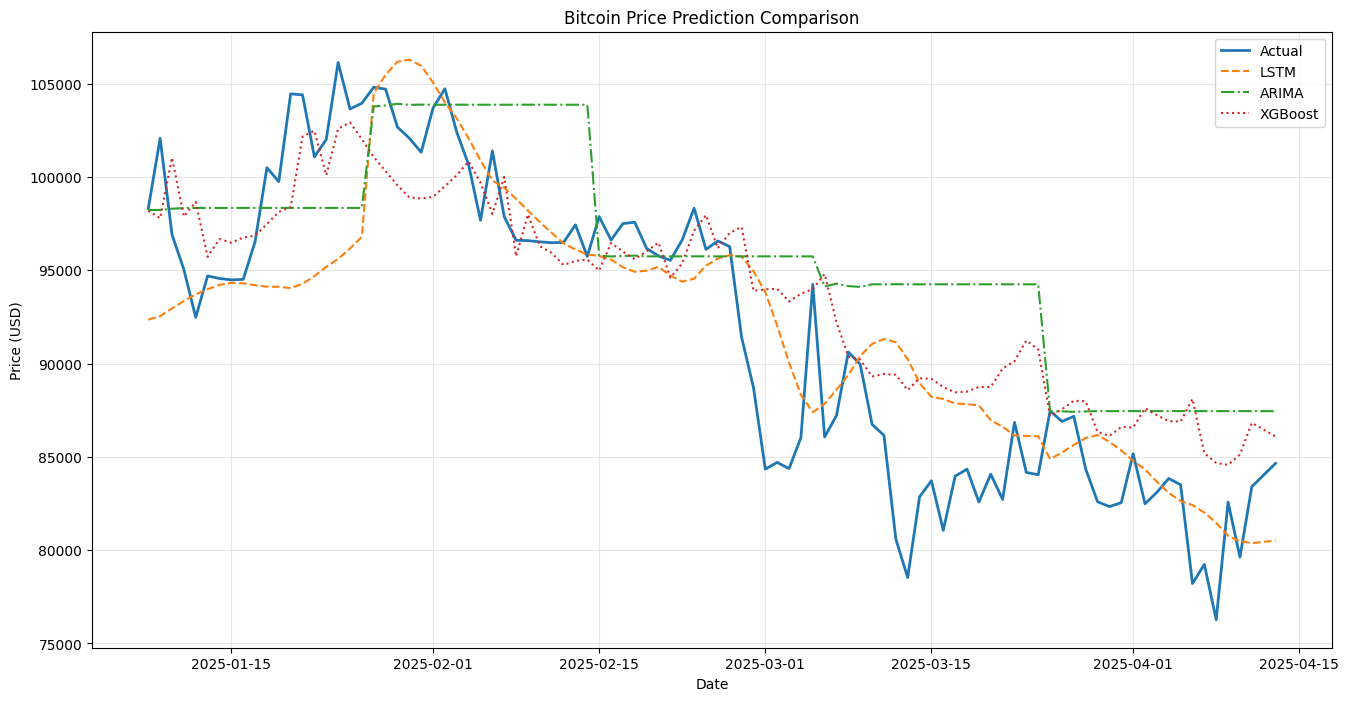

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (316, 50) + inhomogeneous part.

In [25]:
# Display final comparison of models
print("\n--- Final Model Comparison ---")
print(f"{'Model':<10} {'Avg MSE':<12} {'Avg RMSE':<12} {'Avg MAE':<12} {'Avg R²':<12} {'Avg Improvement %':<20}")
print("-" * 70)

for model, metrics in aggregate_metrics.items():
    print(f"{model:<10} {metrics['mse_avg']:<12.4f} {metrics['rmse_avg']:<12.4f} {metrics['mae_avg']:<12.4f} {metrics['r2_avg']:<12.4f} {metrics['improvement_avg']:<20.2f}")

# Plot Results
plt.figure(figsize=(16, 8))
plt.plot(bitcoin_data.index[-len(all_actuals):], all_actuals, label='Actual', linewidth=2)
plt.plot(bitcoin_data.index[-len(all_actuals):], all_predictions['lstm'], label='LSTM', linestyle='--')
plt.plot(bitcoin_data.index[-len(all_actuals):], all_predictions['arima'], label='ARIMA', linestyle='-.')
plt.plot(bitcoin_data.index[-len(all_actuals):], all_predictions['xgboost'], label='XGBoost', linestyle=':')
plt.title('Bitcoin Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance for XGBoost
final_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

# Prepare data for the final XGBoost model
look_back = 10
X_final = []
y_final = []

for i in range(look_back, len(bitcoin_data)):
    features = []
    for col in feature_columns:
        features.extend(bitcoin_data[col].iloc[i-look_back:i].values)
    X_final.append(features)
    y_final.append(bitcoin_data[target_column].iloc[i])

X_final = np.array(X_final)
y_final = np.array(y_final)

final_xgb_model.fit(X_final, y_final)

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_xgb_model, max_num_features=20)
plt.title('XGBoost Feature Importance')
plt.show()

# Summary of model performance
best_model = min(aggregate_metrics.items(), key=lambda x: x[1]['rmse_avg'])[0]
print(f"\n--- Summary ---")
print(f"The best performing model was: {best_model.upper()}")
print(f"Average RMSE: {aggregate_metrics[best_model]['rmse_avg']:.4f}")
print(f"Average improvement over naive model: {aggregate_metrics[best_model]['improvement_avg']:.2f}%")
print("\nThis implementation includes:")
print("- Enhanced feature engineering (MA7, MA30, Volatility, RSI)")
print("- Walk-forward validation with 5 validation steps")
print("- Model comparison (LSTM vs ARIMA vs XGBoost)")
print("- Comprehensive evaluation metrics (MSE, RMSE, MAE, R²)")
print("- Improvement metrics over naive baseline model")
print("- Feature importance analysis")